In [1]:
import networkx as nx
from enum import Enum
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import itertools
import operator

In [2]:
import util

In [3]:
import strategy_vector_manipulator as strategy

In [4]:
import init_sentiment

In [5]:
import stubborn_nodes

In [6]:
# !pip install networkit
# !pip install oct2py
# import get_BTER_graph

In [21]:
ANTIVAX = 1
PROVAX = 0


def get_util(state, d0, d1, sum_x, alpha, C, gamma, delta, n):
  'C = C_v is passed here'

  # case 1: anti-vaxx with herd immunity
  if(state == 1 and sum_x < (1-gamma) * n):
    return alpha*d1 + delta
  
  #case2: anti vaxx withouth herd immunity
  if(state == 1):
    return alpha*d1

  #case3: else pro vaxx
  return alpha * d0 + C


get_util(0, 5, 2, 8, 1, 2, 0.9, 1, 10)

7

In [22]:
def halfSeqBR(state, graph, x, alpha, C, gamma, delta, stubborn, D, verbose):
  'Here C is passed as a vector/dict'

  n = len(graph)
  sum_x = sum(x.values())

  A = [i for i in graph.nodes if x[i] == state and i not in stubborn and 
       get_util(state = 1-x[i], d0 = D[0][i], d1 = D[1][i], sum_x = sum_x, alpha = alpha, C = C[i], gamma = gamma, delta=delta, n=n)
        > get_util(state = x[i], d0 = D[0][i], d1 = D[1][i], sum_x = sum_x, alpha = alpha, C = C[i], gamma = gamma, delta=delta, n=n)]

  flip_len = len(A)
  t = 0
  while A:
    t = t + 1
    i = A.pop(0)
    
    if(x[i] == 1-state):
      continue
    
    x[i] = 1-state
    sum_x += (-1)**state
    for j in graph.neighbors(i):
      D[state][j] -= 1
      D[1-state][j] += 1 
      if x[j] == state and j not in stubborn and get_util(state = 1-x[j], d0 = D[0][j], d1 = D[1][j], sum_x = sum_x, alpha = alpha, C = C[j], gamma = gamma, delta=delta, n=n) > get_util(state = x[j], d0 = D[0][j], d1 = D[1][j], sum_x = sum_x, alpha = alpha, C = C[j], gamma = gamma, delta=delta, n=n):
        A.append(j)
        flip_len += 1


    if (random.random() < verbose):
      print("antivax at time ", t, ": ", sum(x.values())," Probability: ", sum(x.values()) / n)
      print("size of A: ", len(A))


        
  print(state, " to ", 1-state, " flipped: ", flip_len)
  return x, D

In [23]:
def getD(graph, x):
  D0 = {}
  D1 = {}
  for i in graph.nodes:
    d1 = 0
    d0 = 0
    for j in graph.neighbors(i):
      if(x[j] == 0):
        d0 += 1
      else:
        d1 += 1
    
    D0.update({i:d0})
    D1.update({i:d1})

  D = [D0, D1]
  return D

In [24]:
def seqBR(graph, strategy, alpha, gamma, C, delta, stubborn, verbose):
  D = getD(graph, strategy)
  x1, D = halfSeqBR(state=0, graph=graph, x=strategy, alpha=alpha, gamma=gamma, C=C, delta=delta, verbose=verbose, stubborn=stubborn, D=D)
  x2, D = halfSeqBR(state=1, graph=graph, x=x1, alpha=alpha, gamma=gamma, C=C, delta=delta, verbose=verbose, stubborn=stubborn, D=D)
  
  
  #sanity check
  x3, D = halfSeqBR(state=0, graph=graph, x=x2, alpha=alpha, gamma=gamma, C=C, delta=delta, verbose=verbose, stubborn=stubborn, D=D)
  
  if(x2 != x3):
        print("seqBR didn't reach NE")
  return x2

In [25]:
### Experiment 3
### let's understand the antivax nodes in NE
### Set hyperparams here
#############################################

RUN_THIS = True
PARALLEL = False

INIT = "random"
STUBBORN = "none"

alpha = 1
C_list = [[2 for i in range(len(g))]]  #### C is a vector now
gamma_list = [0.9]
delta_list = [0]

PROB_PRO = 0.7
PROB_NEUTRAL = 0.0
PROB_ANTI = 1 - PROB_PRO

NUM_ITERATION = 1

In [26]:
anti_degree_global_count = {} # dictionary of lists

if RUN_THIS and __name__ == "__main__":

  anti_degree_list = []
  anti_cluster_coef_list = []

  for gamma, C, delta in itertools.product(gamma_list, C_list, delta_list):
#     if(delta > C):
#       continue
    anti_degree_local_count = {} # dictionary of ints

    for t in range(NUM_ITERATION):

      init_sentiments_dict = init_sentiment.get_init_sentiments(INIT=INIT, graph = g, PROB_ANTI= PROB_ANTI)
      stubborn = stubborn_nodes.get_stubborn_nodes(g, 0, "none")
        
      strategyNE = seqBR(verbose = 0.00, stubborn = stubborn, graph=g, strategy= init_sentiments_dict, alpha = alpha, gamma=gamma, C = C, delta = delta) 
      # plot(x = range(len(antivax_history)), y = antivax_history, title = "gamma = {}, delta = {}, C = {}".format(gamma, delta, C), xlabel="# Epochs", ylabel="# Antivaccine nodes")
      antivaxNE = strategy.get_antivax(strategyNE)

      for i in antivaxNE:
        if not g.degree[i] in anti_degree_local_count.keys():
          anti_degree_local_count[g.degree[i]] = 0
        
        anti_degree_local_count[g.degree[i]] += 1
        anti_degree_list.append(g.degree[i])
        anti_cluster_coef_list.append(nx.clustering(g,i))
      
      # print(anti_degree_local_count)

      for deg, count in anti_degree_local_count.items():
        if not deg in anti_degree_global_count.keys():
          anti_degree_global_count[deg]=[]

        anti_degree_global_count[deg].append(count)
#     save_obj(anti_degree_global_count, 'anti_degree_global_count')
#     save_obj(anti_cluster_coef_list, 'anti_cluster_coef_list')

0  to  1  flipped:  25
1  to  0  flipped:  9163
0  to  1  flipped:  0


In [321]:
'''Load Graph'''
############# params of graph ############################
N = 1000
M = 20
PROB_TRIANGLE = 0.3
prob_edge = 0.2
#########################################################
# g = nx.erdos_renyi_graph(n=N, p = prob_edge, seed = 42)
# g = nx.expected_degree_graph(w=[20 for i in range(N)], seed=42)
# g = nx.read_edgelist("../data/facebook_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/twitter_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/email-EU-core.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_edgelist("../data/p2p-Gnutella04.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############
# g = nx.read_gexf("../data/twitter_sentiment_200.gexf", node_type=None, relabel=False, version='1.1draft')
# d = 5
# g = nx.random_regular_graph(d=d, n = N, seed = 42)

n = len(g)
m = g.number_of_edges()
triangles = sum(nx.triangles(g).values())//3
davg = sum(dict(g.degree).values())/len(g)
ccavg = nx.average_clustering(g)


print('|V| = ', n)
print('|E| = ', m)
print('Triangles: ', triangles)
print('Avg degree: ', davg)
print('CC_avg: ', ccavg)

print(n, ' & ', m , ' & ', triangles, ' & ', davg , ' & ', ccavg)

NetworkXNotImplemented: not implemented for directed type

In [303]:
# nx.draw(g)

In [314]:
# #### Experiment 1
# #### this script plots histogram of number of epochs for NE
# ## varying the init strategy vector with fixed probabilities

# RUN_THIS = True

# PARALLEL = True

# INIT_LIST = ["random", "degree", "cluster"]
# STUBBORN_TYPES_LIST = ["random", "degree", "cluster"]

# alpha = 1
# beta = 1
# # gamma = 0.9
# # C = 70
# # delta = 35 ## herd immunity does not guarantee total immunity
# C_list = [1, 2, 4]
# gamma_list = [0.9]
# delta_list = [0, 1, 2]

# PROB_STUBBORN = 0.05
# PROB_PRO = 0.7
# PROB_NEUTRAL = 0.0
# PROB_ANTI = 0.3

# NUMBER_OF_INIT_STRATEGY = 10

# if RUN_THIS and __name__ == "__main__":

#   for INIT, STUBBORN_TYPE in itertools.product(INIT_LIST, STUBBORN_TYPES_LIST):

#     print(INIT, STUBBORN_TYPE)


#     epoch_list = []
#     labels = []

#     for gamma, delta, C in itertools.product(gamma_list, delta_list, C_list):
#       if(delta > C):
#         continue
#       local_list = []

#       NUM_ITER = NUMBER_OF_INIT_STRATEGY if INIT=="random" else 1
#       for e in range(NUM_ITER):
#         init_sentiments_dict = get_init_sentiments(INIT = INIT, graph = g, PROB_ANTI = PROB_ANTI)
#         stubborn = get_stubborn_nodes(graph = g, PROB_STUBBORN = PROB_STUBBORN, STUBBORN_TYPE = STUBBORN_TYPE )
#         if (PARALLEL):
#           antivax_history, t, strategyNE = simulate_parallel(stubborn = stubborn,TMAX = 20, verbose = 0.001,
#                                                              graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
#         else:
#           antivax_history, t, strategyNE = simulate_sequential(stubborn = stubborn, verbose = 0, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
                
#         local_list.append(t)

#       epoch_list.append(local_list)
#       labels.append("gamma = {}, delta = {}, C = {}".format(gamma, delta, C))

#     # save_obj(epoch_list, 'epoch_list'+INIT+STUBBORN_TYPE)
#     # save_obj(labels, 'labels'+INIT+STUBBORN_TYPE)

#     # epoch_list = load_obj('epoch_list' + INIT+STUBBORN_TYPE)
#     # labels = load_obj('labels' + INIT+STUBBORN_TYPE)
#     plt.figure(figsize=(10,4))
#     plt.hist(epoch_list, bins = 4, density=True, histtype='bar', label=labels)
#     plt.legend(bbox_to_anchor=(1, 1.6), fancybox=True, fontsize = 10)
#     plt.show()


In [56]:
# ##### Experiment 2
# ##### plot # antivax per epoch

# RUN_THIS = False
# PARALLEL = True
# INIT_LIST = ["degree", "cluster"]
# STUBBORN_TYPES_LIST = ["none"]

# alpha = 1
# beta = 1
# # gamma = 0.9
# # C = 70
# # delta = 35 ## herd immunity does not guarantee total immunity

# avg_degree = sum(np.array(nx.degree(g))[:,1])/len(g)
# C_list = [1, 2, 4]
# gamma_list = [0.9]
# delta_list = [0,1,2]

# PROB_STUBBORN = 0.02
# PROB_PRO = 0.9
# PROB_NEUTRAL = 0.0
# PROB_ANTI = 1-PROB_PRO

# NUMBER_OF_INIT_STRATEGY = 1

# if RUN_THIS and __name__ == "__main__":

#   for INIT, STUBBORN_TYPE in itertools.product(INIT_LIST, STUBBORN_TYPES_LIST):

#     print(INIT, STUBBORN_TYPE)

#     init_sentiments_dict = get_init_sentiments(INIT = INIT, graph= g, PROB_ANTI= PROB_ANTI)  
#     stubborn = get_stubborn_nodes(graph = g, PROB_STUBBORN = PROB_STUBBORN, STUBBORN_TYPE = STUBBORN_TYPE )

#     lines = []

#     for gamma, C, delta in itertools.product(gamma_list, C_list, delta_list):
#       if(delta > C):
#         continue

#       if (PARALLEL):
#         antivax_history, t, strategyNE = simulate_parallel(stubborn = stubborn, TMAX = 20, verbose = 0, 
#                                                            graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
#       else:
#         antivax_history, t, strategyNE = simulate_sequential(stubborn = stubborn,
#                                                              verbose = 0, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
      
#       # label = "\u03B4 = {}d, C = {}d".format(float(delta/avg_degree), float(C/avg_degree))
#       label = "\u03B4 = {}, C = {}".format(delta, C)

#       lines += plot(showplot=False, x = range(len(antivax_history)), y = antivax_history, title="", label = label, xlabel="# Epochs", ylabel="# Antivaccine nodes")
#       # plt.show()
#       plt.legend()
#       print("Time to converge:", t)

#     # plt.rcParams.update({'font.size': 8})
#     # labels = [l.get_label() for l in lines]
#     # plt.legend(lines, labels)

#     plt.show()
    

In [57]:
# for i in g.nodes:
#   continue

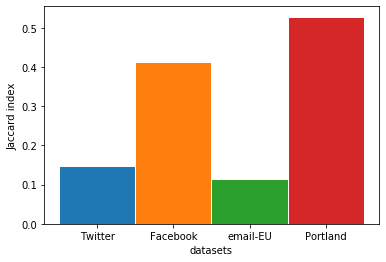

In [79]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import operator as o

import numpy as np

plt.rcParams.update({'font.size': 10})
weights = np.ones_like(anti_cluster_coef_list)/float(len(anti_cluster_coef_list))

dataset = [
    "Twitter-combined",
    "Facebook-combined",
    "email-Eu-core",
    "Portland"
]


barWidth = 0.25
bars=[[0.14856861780619773], 
      [0.4129244249726177],
      [0.11312217194570136],
      [0.5280382647682251]
]

# Set position of bar on X axis
r = np.zeros_like(bars)
r[0] = np.arange(len(bars[0]))
for i in range(1,len(r)):
  for j in range(0, len(r[0])):
    r[i][j] = r[i-1][j] + barWidth

# Make the plot
for i in range(len(bars)):
  plt.bar(r[i], bars[i],  width=barWidth, edgecolor='white', label=dataset[i])

 
# Add xticks on the middle of the group bars
plt.xlabel('datasets')
plt.ylabel('Jaccard index')
plt.xticks([r/4  for r in range(len(bars))], ['Twitter', 'Facebook', 'email-EU', 'Portland', '-', '-'])
# Create legend & Show graphic
# plt.legend(loc='upper right', bbox_to_anchor=(0, 0))
# plt.legend()
plt.show()


In [ ]:
# TO_PLOT = 20

# def boxplot_histogram(dict1, bins=5):
#   labels = [key for key in sorted(dict1.keys())]
#   data =  [dict1[key] for key in sorted(dict1.keys())]


#   hist_data = []
#   hist_label = []
#   local_data = []
#   for i in range(len(data)):
#     local_data.extend(data[i])
#     if(i!=0 and i%bins == 0):
#       hist_data.append(local_data)
#       hist_label.append(labels[i])
#       local_data = []

#   if(local_data != []):
#       hist_data.append(local_data)
#       hist_label.append(labels[-1])

#   # print(hist_data[15])
#   # print(hist_label)

#   plt.rcParams.update({'font.size': 10})
#   plt.boxplot(hist_data[:TO_PLOT])
#   plt.xticks(range(1, TO_PLOT+1), hist_label[:TO_PLOT])
#   plt.xlabel("Degree of nodes in NE")
#   plt.ylabel("Number of nodes")
#   # plt.show()
#   # fig = plt.gcf()
#   # fig.set_size_inches(20, 15)
#   # fig.savefig('boxplot.png', dpi=200)



# RUN_THIS = True

# if RUN_THIS:
#   anti_degree_global_count = load_obj('anti_degree_global_count')

#   boxplot_histogram(anti_degree_global_count, bins=5)

In [ ]:
# from math import log
# TO_PLOT = 100

# def boxplot_histogram(dict1, bins=5):
#   labels = [key for key in sorted(dict1.keys())][:TO_PLOT]
#   data =  [ log(sum(dict1[key])/len(dict1[key])) for key in sorted(dict1.keys())][:TO_PLOT]
#   data = [i if i==0 else log(i) for i in data]

#   print(labels)
#   print(data)


#   # plt.rcParams.update({'font.size': 10})
#   plt.plot(labels, data)
#   # plt.xticks(range(1, len(hist_data) +1), hist_label)
#   plt.xlabel("Degree of nodes in NE")
#   plt.ylabel("log(Number of anti-vaccine nodes)")
#   plt.show()
#   # fig = plt.gcf()
#   # fig.set_size_inches(20, 15)
#   # fig.savefig('boxplot.png', dpi=200)



# RUN_THIS = True

# if RUN_THIS:
#   anti_degree_global_count = load_obj('anti_degree_global_count')

#   boxplot_histogram(anti_degree_global_count, bins=5)

In [ ]:
# # g = nx.read_edgelist("twitter_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap twitter data #############
 
# # g = nx.read_edgelist("facebook_combined.txt", create_using = nx.Graph(), nodetype=int) ########### snap facebook data #############

# g = nx.read_edgelist("email-Eu-core.txt", create_using = nx.Graph(), nodetype=int) ########### snap email-Eu-core data #############


# # g = nx.read_edgelist("G_bter_ca-AstroPh-simple.txt", create_using = nx.Graph(), nodetype=int) ########### snap astoph data #############


# clustering = nx.clustering(g)
# plt.rcParams.update({'font.size': 12})
# # weights = np.ones_like(list(anti_cluster_coef_list))/len(anti_cluster_coef_list)
# weights = np.ones_like(list(clustering.values()))/len(clustering.values())

# print(clustering.values())
# plt.xlabel('Clustering coefficient')
# # plt.hist(anti_cluster_coef_list, weights = weights, bins = 40)
# plt.hist(clustering.values(), weights = weights, bins = 40)


In [ ]:
# ##### Experiment 4
# ##### histogram curve varied with parameters

# RUN_THIS = True
# PARALLEL = True
# INIT_LIST = ["random", "degree", "cluster"]


# #
# alpha = 1
# beta = 1
# # gamma = 0.9
# # C = 70
# # delta = 35 ## herd immunity does not guarantee total immunity
# C_list = [1, 2, 4]
# gamma_list = [0.9]
# delta_list = [1, 2]

# PROB_PRO = 0.7
# PROB_NEUTRAL = 0.0
# PROB_ANTI = 0.3

# if RUN_THIS and __name__ == "__main__":

#   for INIT in INIT_LIST:

#     NUM_ITER = INIT
#     init_sentiments_dict = get_init_sentiments(INIT = INIT, graph= g, PROB_ANTI= PROB_ANTI)  

#     lines = []

#     for gamma, C, delta in itertools.product(gamma_list, C_list, delta_list):
#       if(delta > C):
#         continue

#       if (PARALLEL):
#         antivax_history, t, strategyNE = simulate_parallel(TMAX = 20, verbose = 0, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
#       else:
#         antivax_history, t, strategyNE = simulate_sequential(verbose = 0, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
                  
#       antivaxNE = get_antivax(strategyNE)

#       for i in antivaxNE:
#         anti_cluster_coef_list.append(nx.clustering(g,i))
#       plt.legend()
      

#     plt.rcParams.update({'font.size': 8})
#     labels = [l.get_label() for l in lines]
#     plt.legend(lines, labels)
#     plt.show()
    

In [ ]:
# plt.hist(anti_degree_list, bins = 'auto', label="Histogram of degree of Antivaccine nodes in NE")
# plt.hist(anti_cluster_coef_list, bins='auto')

# def boxplot_dictionary_in_chunks(dict1, split):
#   # labels, data = [*zip(*dict1.items())]  # 'transpose' items to parallel key, value lists

#   # or backwards compatable    
#   labels = [key for key in sorted(dict1.keys())]
#   data =  [dict1[key] for key in sorted(dict1.keys())]

#   chunk = len(data)//split

#   for i in range(split):
#     plt.boxplot(data[i* chunk : (i+1)*chunk])
#     plt.xticks(range(1 , chunk+1), labels[i* chunk: (i+1)*chunk])
#     plt.xlabel("Degree of nodes in NE")
#     plt.ylabel("Number of nodes")
#     plt.show()

#     # fig = plt.gcf()
#     # fig.set_size_inches(40, 5)
#     # fig.savefig('boxplot.png', dpi=200)


#   plt.boxplot(data[split* chunk : -1])
#   plt.xticks(range(len(labels[split* chunk : -1])), labels[split* chunk : -1])
#   plt.xlabel("Degree of nodes in NE")
#   plt.ylabel("Number of nodes")
#   plt.show()


# RUN_THIS = False

# if RUN_THIS:
#   boxplot_dictionary_in_chunks(anti_degree_global_count, split=6)

In [ ]:
# ### connect subgraph and make them antivax
# #########################################

# RUN_THIS = True
# INIT = "random"

# k = 100
# S = random.sample(range(g.number_of_nodes()), k)

# for i in S:
#   for j in S:
#     if not g.has_edge(i,j):
#       g.add_edge(i,j)


# #### this script plots histogram of number of epochs for NE
# ## varying the init strategy vector with fixed probabilities

# alpha = 0
# beta = 1
# # gamma = 0.9
# # C = 70
# # delta = 35 ## herd immunity does not guarantee total immunity
# C_list = [0]
# gamma_list = [0.9]
# delta_list = [35]

# PROB_PRO = 0.7
# PROB_NEUTRAL = 0.0
# PROB_ANTI = 0.3

# if RUN_THIS and __name__ == "__main__":

#   epoch_list = []
  
#   for gamma in gamma_list:
#     for delta in delta_list:
#       for C in C_list:


#         init_sentiments_dict = get_init_sentiments()

#         make_antivax(init_sentiments_dict, S)

#         antivax_history, t, strategyNE = simulate_sequential(verbose = 1, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 

#         plot(x = range(len(antivax_history)), y = antivax_history, title = "gamma = {}, delta = {}, C = {}".format(gamma, delta, C), xlabel="# Epochs", ylabel="# Antivaccine nodes")


#   print( is_subset( S, get_antivax(strategyNE=strategyNE) ) )
#   print(S)
#   print(get_antivax( strategyNE= strategyNE))

degree random
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
antivax at time  0 :  11  Probability:  0.011
...
antivax at time  0 :  21  Probability:  0.021
...
...
...
...
...
antivax at time  0 :  41  Probability:  0.041
...
δ = 1, C = 4
...
...
...
...
...
antivax at time  0 :  24  Probability:  0.024
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 4


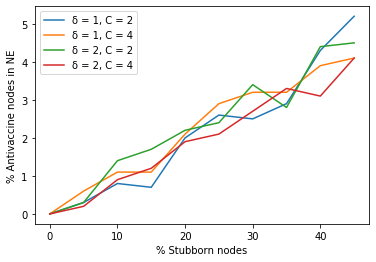

degree degree
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 4
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 4


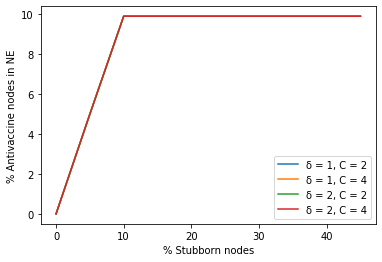

degree cluster
...
antivax at time  0 :  0  Probability:  0.0
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
δ = 1, C = 2
...
antivax at time  0 :  0  Probability:  0.0
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
...
...
δ = 1, C = 4
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
δ = 2, C = 4


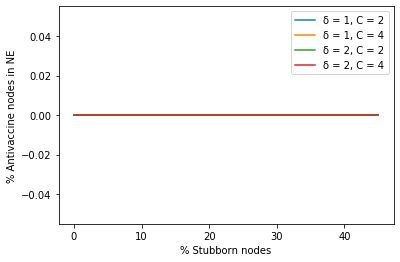

cluster random
...
...
antivax at time  0 :  9  Probability:  0.009
...
...
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
antivax at time  0 :  16  Probability:  0.016
...
...
...
...
...
...
...
δ = 1, C = 4
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
antivax at time  0 :  18  Probability:  0.018
...
...
...
...
...
...
δ = 2, C = 4


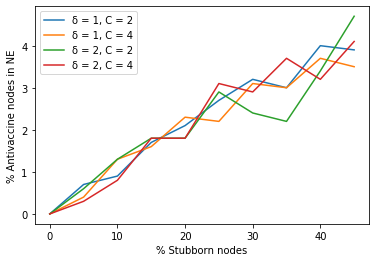

cluster degree
...
...
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 4
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
...
...
...
antivax at time  0 :  0  Probability:  0.0
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 4


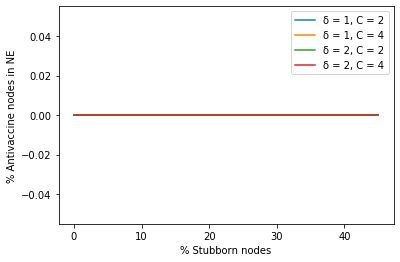

cluster cluster
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 1, C = 4
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 2
...
...
...
...
...
...
...
...
...
...
δ = 2, C = 4


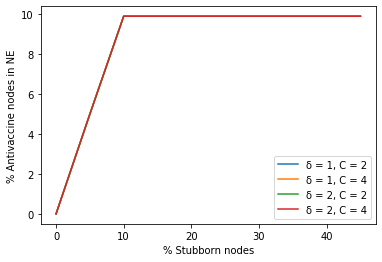

In [ ]:
# ## Experiment 5
# ### stubborn nodes
# #########################################

# # g = nx.read_edgelist("p2p-Gnutella04.txt", create_using = nx.Graph(), nodetype=int) ########### snap gnutella04 data #############

# # ############# params of graph ############################
# N = 1000
# M = 20
# PROB_TRIANGLE = 0.7
# # #########################################################

# g = nx.newman_watts_strogatz_graph(N, M, PROB_TRIANGLE, seed=42) ########### toy data #######



# RUN_THIS = True

# PARALLEL = False

# INIT_LIST = ["degree","cluster"]
# STUBBORN_TYPES_LIST = ["random", "degree", "cluster"]

# alpha = 1
# beta = 1
# # gamma = 0.9
# # C = 70
# # delta = 35 ## herd immunity does not guarantee total immunity
# C_list = [2,4]
# gamma_list = [0.9]
# delta_list = [1,2]

# PROB_STUBBORN_LIST = np.arange(0, 0.5, 0.05)
# PROB_PRO = 0.9
# PROB_ANTI = 1 - PROB_PRO

# NUMBER_OF_INIT_STRATEGY = 1

# if RUN_THIS and __name__ == "__main__":


#   net_size = len(g)
#   for INIT, STUBBORN_TYPE in itertools.product(INIT_LIST, STUBBORN_TYPES_LIST):

#     print(INIT, STUBBORN_TYPE)


#     epoch_list = []
#     labels = []
#     lines = []
#     for gamma, delta, C in itertools.product(gamma_list, delta_list, C_list):
#       if(delta > C):
#         continue
#       local_list = []

#       NUM_ITER = NUMBER_OF_INIT_STRATEGY if INIT=="random" else 1
      
#       antivax_size = []
#       for PROB_STUBBORN in PROB_STUBBORN_LIST:
#         init_sentiments_dict = get_init_sentiments(INIT = INIT, graph = g, PROB_ANTI = PROB_ANTI)
#         stubborn = get_stubborn_nodes(graph = g, PROB_STUBBORN = PROB_STUBBORN, STUBBORN_TYPE = STUBBORN_TYPE )


#         if (PARALLEL):
#           antivax_history, t, strategyNE = simulate_parallel(stubborn = stubborn, TMAX = 20, verbose = 0, 
#                                                             graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
#         else:
#           antivax_history, t, strategyNE = simulate_sequential(stubborn = stubborn,
#                                                               verbose = 0.1, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 

#         print("...")
#         antivax_size.append(len(get_antivax(strategyNE=strategyNE))/net_size*100)

#       label = "\u03B4 = {}, C = {}".format(delta, C)
#       print(label)
#       lines += plot(showplot=False, x = PROB_STUBBORN_LIST*100, y = antivax_size, title="", 
#                     label = label, xlabel="% Stubborn nodes", ylabel="% Antivaccine nodes in NE")
#       labels.append(label)
#       # plt.show()
#       # plt.legend()

#     plt.legend(lines, labels)
#     plt.show()


degree
...
antivax at time  1 :  384  Probability:  0.09507303788066353
...
antivax at time  1 :  859  Probability:  0.21267640505075514
...
antivax at time  1 :  962  Probability:  0.23817776677395394
...
antivax at time  1 :  1444  Probability:  0.3575142361970785
antivax at time  7 :  1763  Probability:  0.4364941817281505
...
antivax at time  1 :  1786  Probability:  0.4421886605595444
antivax at time  7 :  2291  Probability:  0.5672196088140629
antivax at time  9 :  2324  Probability:  0.5753899480069324
antivax at time  12 :  2335  Probability:  0.5781133944045556
...
antivax at time  1 :  2131  Probability:  0.5276058430304531
antivax at time  7 :  2672  Probability:  0.6615498885862837
antivax at time  9 :  2697  Probability:  0.6677395394899728
antivax at time  12 :  2707  Probability:  0.6702153998514484
...
antivax at time  1 :  2567  Probability:  0.6355533547907898
antivax at time  7 :  2831  Probability:  0.700916068333746
antivax at time  9 :  2840  Probability:  0.70314

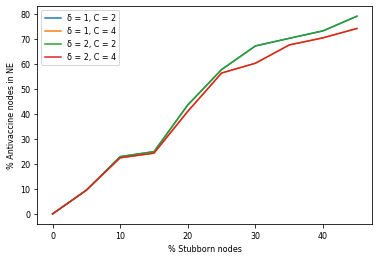

In [ ]:
## Experiment 6
## only stubborn nodes are anti-vaxx


## Experiment 5
### stubborn nodes
#########################################


RUN_THIS = True

PARALLEL = False

STUBBORN_TYPES_LIST = ["degree"]

alpha = 1
beta = 1
# gamma = 0.9
# C = 70
# delta = 35 ## herd immunity does not guarantee total immunity
C_list = [2,4]
gamma_list = [0.9]
delta_list = [1,2]

PROB_STUBBORN_LIST = np.arange(0, 0.5, 0.05)
PROB_PRO = 1
PROB_ANTI = 1 - PROB_PRO

NUMBER_OF_INIT_STRATEGY = 1

INIT = "random"

if RUN_THIS and __name__ == "__main__":

  net_size = len(g)
  for STUBBORN_TYPE in STUBBORN_TYPES_LIST:

    print(STUBBORN_TYPE)

    epoch_list = []
    labels = []
    lines = []
    for gamma, delta, C in itertools.product(gamma_list, delta_list, C_list):
      if(delta > C):
        continue
      local_list = []

      NUM_ITER = NUMBER_OF_INIT_STRATEGY if INIT=="random" else 1
      
      antivax_size = []
      for PROB_STUBBORN in PROB_STUBBORN_LIST:
        init_sentiments_dict = get_init_sentiments(INIT = INIT, graph = g, PROB_ANTI = PROB_ANTI)
        stubborn = get_stubborn_nodes(graph = g, PROB_STUBBORN = PROB_STUBBORN, STUBBORN_TYPE = STUBBORN_TYPE )

        init_sentiment_dict = make_antivax(init_sentiments_dict, stubborn)


        if (PARALLEL):
          antivax_history, t, strategyNE = simulate_parallel(stubborn = stubborn, TMAX = 20, verbose = 0, 
                                                            graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
        else:
          antivax_history, t, strategyNE = simulate_sequential(stubborn = stubborn,
                                                              verbose = 0.1, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 

        print("...")
        antivax_size.append(len(get_antivax(strategyNE=strategyNE))/net_size*100)

      label = "\u03B4 = {}, C = {}".format(delta, C)
      print(label)
      lines += plot(showplot=False, x = PROB_STUBBORN_LIST*100, y = antivax_size, title="", 
                    label = label, xlabel="% Stubborn nodes", ylabel="% Antivaccine nodes in NE")
      labels.append(label)
      # plt.show()
      # plt.legend()

    plt.legend(lines, labels)
    plt.show()


In [ ]:
## Experiment 7
## K-core

import matplotlib.pyplot as plt


g = nx.read_edgelist("portland.txt", create_using = nx.Graph(), nodetype=int) 
## Experiment 5
### stubborn nodes
#########################################


RUN_THIS = True

PARALLEL = False

INIT_LIST = ["centrality"]
STUBBORN_TYPES_LIST = ["centrality"]

alpha = 1
beta = 1
# gamma = 0.9
# C = 70
# delta = 35 ## herd immunity does not guarantee total immunity
C_list = [4]
gamma_list = [0.9]
delta_list = [1]

PROB_STUBBORN_LIST = np.arange(0, 0.5, 0.05)
PROB_PRO = 0.9
PROB_ANTI = 1 - PROB_PRO

NUMBER_OF_INIT_STRATEGY = 1

if RUN_THIS and __name__ == "__main__":


  net_size = len(g)
  for INIT, STUBBORN_TYPE in itertools.product(INIT_LIST, STUBBORN_TYPES_LIST):

    print(INIT, STUBBORN_TYPE)


    epoch_list = []
    labels = []
    lines = []
    for gamma, delta, C in itertools.product(gamma_list, delta_list, C_list):
      if(delta > C):
        continue
      local_list = []

      NUM_ITER = NUMBER_OF_INIT_STRATEGY if INIT=="random" else 1
      
      antivax_size = []
      for PROB_STUBBORN in PROB_STUBBORN_LIST:
        init_sentiments_dict = get_init_sentiments(INIT = INIT, graph = g, PROB_ANTI = PROB_ANTI)
        stubborn = get_stubborn_nodes(graph = g, PROB_STUBBORN = PROB_STUBBORN, STUBBORN_TYPE = STUBBORN_TYPE )


        if (PARALLEL):
          antivax_history, t, strategyNE = simulate_parallel(stubborn = stubborn, TMAX = 20, verbose = 0, 
                                                            graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 
        else:
          antivax_history, t, strategyNE = simulate_sequential(stubborn = stubborn,
                                                              verbose = 0.1, graph=g, strategy= init_sentiments_dict, alpha = alpha, beta=beta, gamma=gamma, C = C, delta = delta) 

        print("...")
        antivax_size.append(len(get_antivax(strategyNE=strategyNE))/net_size*100)

      anti_vax_nodes = get_antivax(strategyNE)
      anti_vax_subgraph = g.subgraph(anti_vax_nodes)

      core_dict = nx.algorithms.core.core_number(anti_vax_subgraph)
      plt.hist(core_dict.values(), bins = 'auto')
      plt.show()

In [ ]:
nx.algorithms.core.core_number??